
--- INFO DEL DATASET ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    705 non-null    int64  
 1   Age                           705 non-null    int64  
 2   Gender                        705 non-null    object 
 3   Academic_Level                705 non-null    object 
 4   Country                       705 non-null    object 
 5   Avg_Daily_Usage_Hours         705 non-null    float64
 6   Most_Used_Platform            705 non-null    object 
 7   Affects_Academic_Performance  705 non-null    object 
 8   Sleep_Hours_Per_Night         705 non-null    float64
 9   Mental_Health_Score           705 non-null    int64  
 10  Relationship_Status           705 non-null    object 
 11  Conflicts_Over_Social_Media   705 non-null    int64  
 12  Addicted_Score                705 non-

C:\Users\39327\AppData\Local\Temp\ipykernel_8032\373975999.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Affects_Academic_Performance'] = df['Affects_Academic_Performance'].replace({'Yes':1, 'No':0, 'yes':1, 'no':0})


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0

Confusion Matrix:
[[50  0]
 [ 0 91]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        91

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141


Top feature importances (top 20):
Engagement_Level                       0.247996
Conflicts_Over_Social_Media            0.220320
Addicted_Score                         0.147345
Mental_Health_Score                    0.137343
Sleep_Hours_Per_Night                  0.074097
Avg_Daily_Usage_Hours                  0.060071
Most_Used_Platform_Facebook            0.010910
Most_Used_Platform_TikTok              0.010175
Most_Used_Platform_LinkedIn            0.006902
Country_Denmark                        0.006176
Country_Switzerland               

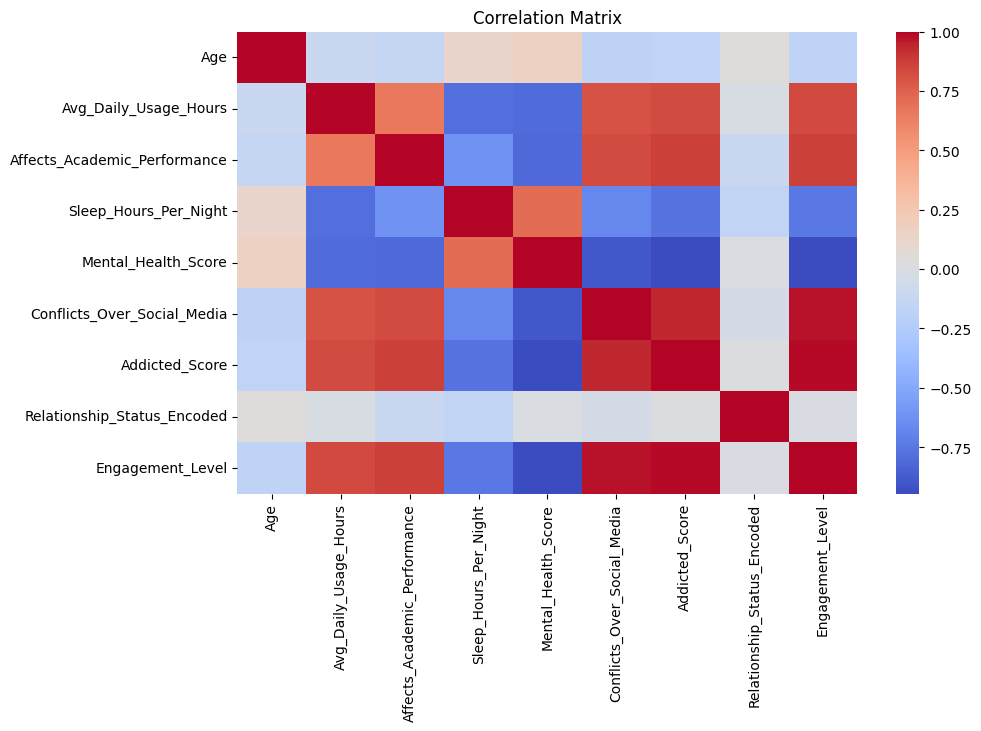

=== Colonne IDENTICHE al target ===
[]
=== Mutual Information ===
Engagement_Level               0.652645
Conflicts_Over_Social_Media    0.629696
Addicted_Score                 0.596329
Mental_Health_Score            0.539727
Avg_Daily_Usage_Hours          0.309161
Sleep_Hours_Per_Night          0.278844
Relationship_Status_Encoded    0.018046
Age                            0.000000
dtype: float64
Age                             0.0
Avg_Daily_Usage_Hours           0.0
Sleep_Hours_Per_Night           0.0
Mental_Health_Score             0.0
Conflicts_Over_Social_Media     0.0
Addicted_Score                  0.0
Relationship_Status_Encoded     0.0
Engagement_Level                0.0
Gender_Female                   0.0
Gender_Male                     0.0
Academic_Level_Graduate         0.0
Academic_Level_High School      0.0
Academic_Level_Undergraduate    0.0
Country_Afghanistan             0.0
Country_Albania                 0.0
Country_Andorra                 0.0
Country_Argentina      

In [ ]:
"""
Pipeline completo: EDA -> Pulizia -> Feature Engineering -> Encoding -> Modello ML
File: ml_pipeline_social_media.py
Istruzioni: posiziona 'Social_Media.csv' nella stessa cartella oppure fornisci il path.
Scegli il target impostando la variabile `TARGET` sotto.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_error)

# ----------------------------- CONFIG -----------------------------
CSV_PATH = 'Social_Media.csv'  # modifica se serve
TARGET = 'Affects_Academic_Performance'  # es: 'Affects_Academic_Performance' (classif) o 'Addicted_Score' (regression)
RANDOM_STATE = 42
TEST_SIZE = 0.2
SAVE_MODEL = False  # se True salva modello in 'model.pkl'

# ----------------------------- UTIL -----------------------------

def load_data(path=CSV_PATH):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File non trovato: {path}")
    df = pd.read_csv(path)
    return df


def initial_checks(df):
    print('\n--- INFO DEL DATASET ---')
    print(df.info())
    print('\n--- DESCRIZIONE STATISTICA ---')
    print(df.describe(include='all'))
    print('\n--- PRIME 10 RIGHE ---')
    print(df.head(10))
    print('\n--- VALORI NULLI (%) PER COLONNA ---')
    print((df.isnull().sum()/len(df))*100)


# ----------------------------- CLEANING & FEATURE ENG -----------------------------

def clean_and_feature_engineer(df):
    df = df.copy()

    # 0) Drop identifier
    if 'Student_ID' in df.columns:
        df.drop(columns=['Student_ID'], inplace=True)

    # 1) Strip strings
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip()

    # 2) Standardize Yes/No to 1/0 for Affects_Academic_Performance if present
    if 'Affects_Academic_Performance' in df.columns:
        df['Affects_Academic_Performance'] = df['Affects_Academic_Performance'].replace({'Yes':1, 'No':0, 'yes':1, 'no':0})
        # if still object, try to convert
        if df['Affects_Academic_Performance'].dtype == 'object':
            df['Affects_Academic_Performance'] = pd.to_numeric(df['Affects_Academic_Performance'], errors='coerce')

    # 3) Convert relationship status to ordered numeric if present
    if 'Relationship_Status' in df.columns:
        rel_map = {'Single':0, 'In Relationship':1, 'Complicated':2}
        df['Relationship_Status_Encoded'] = df['Relationship_Status'].map(rel_map)

    # 4) Create Engagement_Level = Addicted_Score + Conflicts_Over_Social_Media (example)
    if all(col in df.columns for col in ['Addicted_Score', 'Conflicts_Over_Social_Media']):
        df['Engagement_Level'] = df['Addicted_Score'] + df['Conflicts_Over_Social_Media']

    # 5) Convert categorical columns to category dtype
    cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c!='Affects_Academic_Performance']
    for c in cat_cols:
        df[c] = df[c].astype('category')

    return df


# ----------------------------- PREPARE PIPELINE -----------------------------

def build_preprocessor(df, numeric_features=None, categorical_features=None):
    # default selection
    if numeric_features is None:
        numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
        # remove target if numeric
        if TARGET in numeric_features:
            numeric_features = [c for c in numeric_features if c != TARGET]
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=['category','object']).columns.tolist()

    # Basic imputers and scalers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )

    return preprocessor, numeric_features, categorical_features


# ----------------------------- MODEL TRAIN & EVAL -----------------------------

def train_and_evaluate(df, target=TARGET):
    df = df.copy()

    if target not in df.columns:
        raise ValueError(f"Target '{target}' non trovato nel dataframe")

    # Separate X, y
    X = df.drop(columns=[target])
    y = df[target]

    # Detect task type
    is_classification = y.dropna().unique().size <= 20 and y.dropna().isin([0,1]).all()
    # fallback: if dtype is int and small unique -> classification
    if y.dtype in ["object", 'category']:
        is_classification = True

    preprocessor, numeric_features, categorical_features = build_preprocessor(X)

    if is_classification:
        print('\n--- TASK: CLASSIFICATION ---')
        model = RandomForestClassifier(random_state=RANDOM_STATE)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = None
        try:
            if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
                y_proba = pipeline.predict_proba(X_test)[:,1]
        except Exception:
            y_proba = None

        # Metrics
        print('Accuracy:', accuracy_score(y_test, y_pred))
        print('Precision:', precision_score(y_test, y_pred, zero_division=0))
        print('Recall:', recall_score(y_test, y_pred, zero_division=0))
        print('F1:', f1_score(y_test, y_pred, zero_division=0))
        if y_proba is not None:
            try:
                print('ROC AUC:', roc_auc_score(y_test, y_proba))
            except Exception:
                pass

        print('\nConfusion Matrix:')
        print(confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

        # Feature importances (approximate names after one-hot)
        try:
            feat_names = []
            # numeric feature names
            feat_names += numeric_features
            # onehot encoded feature names
            ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
            cat_cols = categorical_features
            if hasattr(ohe, 'get_feature_names_out'):
                ohe_names = list(ohe.get_feature_names_out(cat_cols))
            else:
                # sklearn <1.0 fallback
                ohe_names = []
            feat_names += ohe_names

            importances = pipeline.named_steps['classifier'].feature_importances_
            fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)
            print('\nTop feature importances (top 20):')
            print(fi)
        except Exception as e:
            print('Impossibile calcolare feature importances:', e)

        if SAVE_MODEL:
            import joblib
            joblib.dump(pipeline, 'model_classification.pkl')
            print('Modello salvato come model_classification.pkl')

        return pipeline

    else:
        print('\n--- TASK: REGRESSION ---')
        model = RandomForestRegressor(random_state=RANDOM_STATE)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        print('MAE:', mean_absolute_error(y_test, y_pred))
        print('MSE:', mean_squared_error(y_test, y_pred))
        print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
        print('R2:', r2_score(y_test, y_pred))

        if SAVE_MODEL:
            import joblib
            joblib.dump(pipeline, 'model_regression.pkl')
            print('Modello salvato come model_regression.pkl')

        return pipeline


# ----------------------------- OPTIONAL: GRID SEARCH  -----------------------------

def grid_search_example(pipeline, X, y, task='classification'):
    if task == 'classification':
        param_grid = {
            'classifier__n_estimators':[50,100],
            'classifier__max_depth':[None,10,20]
        }
    else:
        param_grid = {
            'regressor__n_estimators':[50,100],
            'regressor__max_depth':[None,10,20]
        }

    search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1' if task=='classification' else 'r2')
    search.fit(X, y)
    return search


# ----------------------------- MAIN -----------------------------

if __name__ == '__main__':
    df = load_data(CSV_PATH)
    initial_checks(df)
    df_clean = clean_and_feature_engineer(df)

    print('\n--- DOPO PULIZIA: HEAD ---')
    print(df_clean.head())

    # Se vuoi cambiare target, modifica la variabile TARGET in cima al file
    model_pipeline = train_and_evaluate(df_clean, target=TARGET)

    # Salva un esempio di X preprocessed (facoltativo)
    try:
        preproc = model_pipeline.named_steps.get('preprocessor')
        if preproc is not None:
            X = df_clean.drop(columns=[TARGET])
            X_pre = preproc.transform(X)
            print('\nX preprocessed shape:', X_pre.shape)
    except Exception:
        pass

    print('\n--- PIPELINE COMPLETA ESEGUITA ---')

# Fine file

## 🔍 Leakage & Correlazione – Codice di Diagnostica Avanzata

import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# === 1) CORRELAZIONI SOSPETTE ===
print("=== Correlazioni con il target ===")
corr = df_clean.corr(numeric_only=True)[TARGET].sort_values(ascending=False)
print(corr.head(20))

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_clean.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# === 2) FEATURE DUBBIOSE: IDENTICI AL TARGET O QUASI ===
duplicates = []
for col in df_clean.columns:
    if col != TARGET:
        if df_clean[col].equals(df_clean[TARGET]):
            duplicates.append(col)

print("=== Colonne IDENTICHE al target ===")
print(duplicates)

# === 3) MUTUAL INFORMATION ===
from sklearn.feature_selection import mutual_info_classif

X = df_clean.drop(columns=[TARGET])
y = df_clean[TARGET]
mi = mutual_info_classif(X.select_dtypes(include=[np.number]), y)
mi_scores = pd.Series(mi, index=X.select_dtypes(include=[np.number]).columns).sort_values(ascending=False)

print("=== Mutual Information ===")
print(mi_scores.head(20))

# === 4) PERMUTATION IMPORTANCE TEST ===
from sklearn.inspection import permutation_importance

# Determina lo step corretto
if 'classifier' in model_pipeline.named_steps:
    model_step_name = 'classifier'
else:
    model_step_name = 'regressor'

# Calcola permutation importance
perm = permutation_importance(
    model_pipeline.named_steps[model_step_name],
    model_pipeline.named_steps['preprocessor'].transform(X),
    y,
    n_repeats=10,
    random_state=42
)

# Recupera feature names
feat_names = []
# numeric feature names
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
feat_names += numeric_features
# one-hot encoded categorical names
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
if hasattr(ohe, 'get_feature_names_out'):
    ohe_names = ohe.get_feature_names_out(categorical_features)
    feat_names += list(ohe_names)

perm_scores = pd.Series(perm.importances_mean, index=feat_names)
print(perm_scores.sort_values(ascending=False).head(20))

# === 5) VERIFICA DI VALORI COSTANTI ===
print("=== Colonne a valore costante ===")
constant_cols = [c for c in df_clean.columns if df_clean[c].nunique() == 1]
print(constant_cols)


